# Analisando conteúdos da Netflix no IMDB

## Introdução

A Netflix é uma das plataformas de streaming de vídeo mais populares do mundo, com um catálogo de conteúdo que inclui filmes, séries, documentários e outros formatos. A popularidade dos conteúdos da Netflix é um fator importante para a plataforma, pois influencia a escolha dos conteúdos pelos espectadores.

Este projeto irá analisar um conjunto de dados do [Kaggle](https://www.kaggle.com/), que pode ser encontrado [aqui](https://www.kaggle.com/datasets/thedevastator/netflix-imdb-scores) que contém informações sobre mais de 5.000 títulos da Netflix que nos traz as seguintes informações a respeito dos títulos:

- Título
- Tipo: MOVIE ou SHOW (MOVIE para filme e SHOW para série)
- Descrição: uma breve descrição sobre o que é o conteúdo
- Ano de lançamento: ano em que o conteúdo foi lançado (para o público e não na plataforma da Netflix necessariamente)
- Classificação etária
- Tempo de duração
- IMBD_id: a ID do conteúdo na IMDB
- Avaliação na IMDB
- Número de votos na IMDB

Tendo isso em vista, nós queremos estudar a popularidade desses conteúdos. As perguntas que faremos aos nossos dados são:

- Como podemos avaliar a popularidade de um show baseado nessas informações que temos?
- Quais são os conteúdos mais populares disponíveis?
- Pensando em popularidade, MOVIE ou SHOW são mais populares?
- Há influência do tipo de conteúdo na popularidade?"

Sendo assim, iremos trabalhar com a seguinte hipótese a ser testada:

- O tipo de conteúdo influencia a popularidade, de modo que as séries são, em geral, mais populares do que os filmes.


## Importando bibliotecas e abrindo arquivo

Vamos primeiro importar as bibliotecas usadas e também abrir o arquivo:

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import graficos_e_funcoes_netfliximdb as gf

In [29]:
netflix = gf.pd.read_csv('netflix_imdb.csv', index_col=0)

## Explorando o conjunto de dados

Primeiramente, vamos imprimir as primeiras linhas de nosso conjunto de dados para vermos como ele está:

In [30]:
netflix.head(5)


,id,title,type,description,release_year,age_certification,runtime,imdb_id,imdb_score,imdb_votes
index,,,,,,,,,,
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,tt0075314,8.3,795222.0
1,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,tt0071853,8.2,530877.0
2,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,tt0079470,8.0,392419.0
3,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,tt0070047,8.1,391942.0
4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,tt0063929,8.8,72895.0


Vamos agora explorar uma amostra aleatória do nosso conjunto de dados:

In [31]:
netflix.sample(5)

,id,title,type,description,release_year,age_certification,runtime,imdb_id,imdb_score,imdb_votes
index,,,,,,,,,,
506,tm165809,Bluffmaster!,MOVIE,"Roy is a professional conman, who has raised h...",2005,PG,137,tt0476527,6.6,6313.0
47,tm155792,Teenage Mutant Ninja Turtles,MOVIE,"A quartet of humanoid turtles, trained by thei...",1990,PG,93,tt0100758,6.7,92647.0
4339,tm976519,The App That Stole Christmas,MOVIE,A tech entrepreneur's Christmas shopping app i...,2020,PG,63,tt11378154,3.7,734.0
3387,ts224072,Self Made: Inspired by the Life of Madam C.J. ...,SHOW,This limited series chronicles the incredible ...,2020,TV-MA,47,tt8771910,7.3,11586.0
1573,ts42347,Word Party,SHOW,"Meet Bailey, Franny, Kip and Lulu. They're ado...",2016,TV-Y,20,tt5235950,5.7,349.0


Exploraremos agora as colunas, com seus tipos e contagens de valores não nulos, para detectarmos se temos algum problema com nossos dados em nossa análise.

In [32]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5283 entries, 0 to 5282
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5283 non-null   object 
 1   title              5283 non-null   object 
 2   type               5283 non-null   object 
 3   description        5278 non-null   object 
 4   release_year       5283 non-null   int64  
 5   age_certification  2998 non-null   object 
 6   runtime            5283 non-null   int64  
 7   imdb_id            5283 non-null   object 
 8   imdb_score         5283 non-null   float64
 9   imdb_votes         5267 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 454.0+ KB


Podemos notar aqui:

- Por `id`, `title` e `imdb_id` notamos que temos um total de 5283 conteúdos diferentes listados.
- Por `description` notamos que temos 5 linhas cuja descrição está vazia.
- Por `imdb_score` notamos que todos os conteúdos têm a nota de avaliação. Tudo Ok.
- Por `imdb_votes` notamos que temos 16 linhas que não têm registro de número de votos. Note que essas linhas todas possuem nota, mas não têm informação de quantos votos foram dados para compor essa nota. Precisaremos olhar para isso.
- Por `release_year` notamos que todos os conteúdos possuem o ano de lançamento. Tudo Ok.

Vejamos quais são os títulos cuja descrição está sem informação:

In [33]:
netflix.loc[netflix["description"].isna()]

,id,title,type,description,release_year,age_certification,runtime,imdb_id,imdb_score,imdb_votes
index,,,,,,,,,,
1117,tm681614,Grandmother's Farm,MOVIE,NaN,2013,NaN,71,tt10033686,2.9,74.0
2605,ts90941,"Heidi, bienvenida a casa",SHOW,NaN,2017,TV-Y,46,tt7183310,6.2,20.0
2752,tm407349,The Birth Reborn 2,MOVIE,NaN,2018,PG,91,tt16114198,6.6,5.0
4020,tm1172010,The Lockdown Plan,MOVIE,NaN,2020,NaN,49,tt13079112,6.5,NaN
4393,tm902993,Mama Drama,MOVIE,NaN,2020,NaN,85,tt12424356,6.3,8.0


Note que o título com o `imdb_id: tt13079112` tanto não possui número de votos quanto descrição.

Vamos agora olhar para os conteúdos cujo número de votos está sem informação:

In [34]:
netflix.loc[netflix["imdb_votes"].isna()]

,id,title,type,description,release_year,age_certification,runtime,imdb_id,imdb_score,imdb_votes
index,,,,,,,,,,
918,tm144046,Jackass Presents: Bad Grandpa .5,MOVIE,Bad Grandpa .5 gives you a whole new perspecti...,2014,PG-13,86,tt3766424,6.3,NaN
1111,tm163066,Xenos,MOVIE,"In 2010, Abu Eyad and other young Palestinian ...",2013,NaN,12,tt3289618,7.8,NaN
2669,tm995893,The Crossing,MOVIE,Three Palestinian siblings eagerly attempt to ...,2017,NaN,10,tt7466040,7.5,NaN
3468,tm826563,A Cinderella Story: Christmas Wish,MOVIE,Kat is an aspiring singer-songwriter who dream...,2019,PG,93,tt10326928,5.3,NaN
3796,tm835869,Jarhead: Law of Return,MOVIE,"Major Ronan Jackson, an accomplished fighter p...",2019,R,103,tt10767720,5.6,NaN
3946,tm931436,Welcome to Sudden Death,MOVIE,Jesse Freeman is a former special forces offic...,2020,R,80,tt10804786,4.3,NaN
4020,tm1172010,The Lockdown Plan,MOVIE,NaN,2020,NaN,49,tt13079112,6.5,NaN
4257,tm984018,Cops and Robbers,MOVIE,Animation and activism unite in this multimedi...,2020,PG-13,8,tt13322484,6.9,NaN
4328,tm1113921,In Vitro,MOVIE,'In Vitro' is an otherworldly rumination on me...,2019,NaN,27,tt10545994,7.7,NaN


Podemos notar que:

- São todos do tipo `MOVIE`
- As notas variam entre `4.3` e `7.8`

A seguir, iremos resolver o problema do número de votos. Para isso, usaremos a mediana de votos da categoria filmes para preencher os valores faltantes. A escolha da mediana visa evitar qualquer distorção causada por um possível outlier em nossos dados. Além disso, como observamos que são apenas filmes, nós vamos usar a mediana dessa categoria apenas, em vez de geral.

In [35]:
netflix['imdb_votes'] = netflix.groupby('type')['imdb_votes'].transform(lambda x: x.fillna(x.median()))

Vamos verificar se está tudo certo:

In [36]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5283 entries, 0 to 5282
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5283 non-null   object 
 1   title              5283 non-null   object 
 2   type               5283 non-null   object 
 3   description        5278 non-null   object 
 4   release_year       5283 non-null   int64  
 5   age_certification  2998 non-null   object 
 6   runtime            5283 non-null   int64  
 7   imdb_id            5283 non-null   object 
 8   imdb_score         5283 non-null   float64
 9   imdb_votes         5283 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 454.0+ KB


## Filtragem

Algumas das colunas presentes em nosso conjunto de dados não serão usadas por nós, sendo elas: `id` (usaremos o `imdb_id` invés), `age_certification`, `runtime`, `release_year` e `description`. Vamos retirar elas de nosso conjunto para facilitar a manipulação e visualização:

In [37]:
netflix.drop(columns=["id", "age_certification", "runtime", "description", "release_year"], inplace=True)
netflix.head(5)

,title,type,imdb_id,imdb_score,imdb_votes
index,,,,,
0,Taxi Driver,MOVIE,tt0075314,8.3,795222.0
1,Monty Python and the Holy Grail,MOVIE,tt0071853,8.2,530877.0
2,Life of Brian,MOVIE,tt0079470,8.0,392419.0
3,The Exorcist,MOVIE,tt0070047,8.1,391942.0
4,Monty Python's Flying Circus,SHOW,tt0063929,8.8,72895.0


Agora que temos apenas os dados relevantes para nossa análise, vamos partir para os passos seguintes.

## Popularidade

### Medida de popularidade:

Precisamos pensar em como definir a popularidade de um conteúdo com as informações que temos em nossos dados. Algumas opções iniciais e seus problemas são:

- Avaliação do conteúdo: poderíamos usar a nota no IMDB como critério para avaliar se um conteúdo é popular ou não. Essa nota é dada pelos usuários e pode nos fornecer a opinião do público sobre o conteúdo. Porém, essa abordagem não é boa, pois podemos ter algum título que tenha um número muito baixo de votos, mas uma nota muito alta. Isso nos daria uma falsa impressão de popularidade, apenas porque não tivemos votos suficientes para entender como o público reagiu àquele título.
- Número de votos: o número de votos nos mostra quantas pessoas foram até o IMDB avaliar aquele conteúdo. Pode ser um parâmetro plausível, mas ele nos dá apenas o engajamento que aquele título gerou, ou seja, quantas pessoas se interessaram em avaliá-lo. Estamos desperdiçando aqui a informação de como essas pessoas reagiram ao título específico.

Veja dois histogramas para ilustrar:

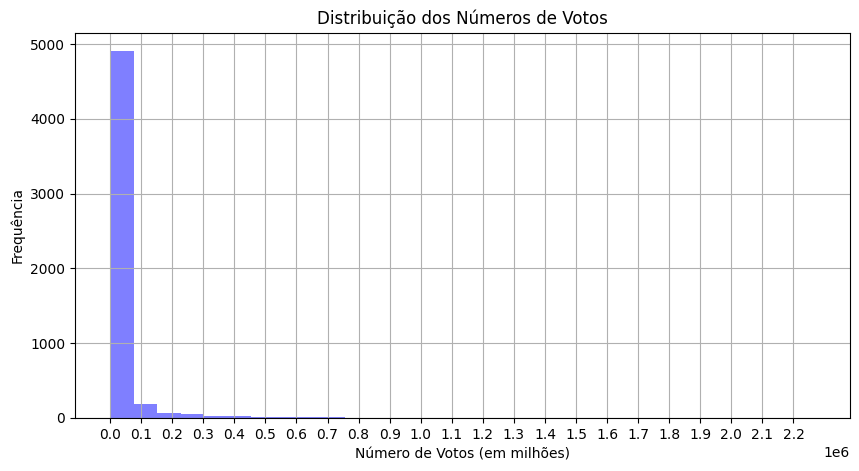

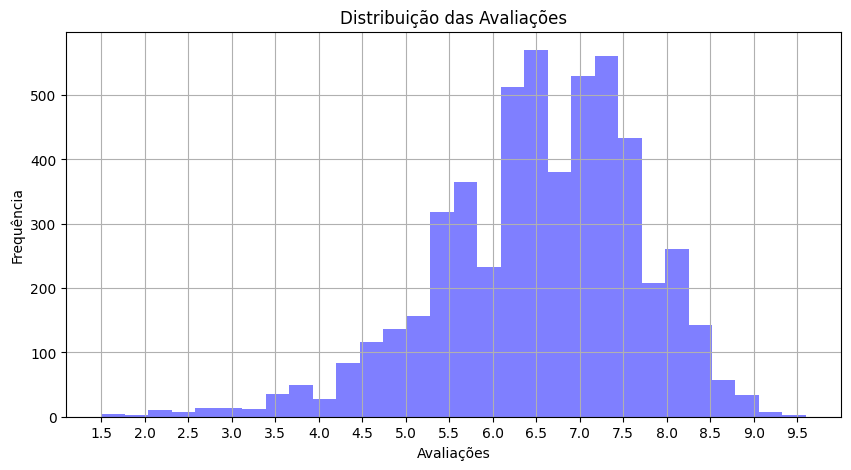

In [38]:
gf.grafico_histograma(netflix, 'imdb_votes', 30, 100000, 'Distribuição dos Números de Votos', 'Número de Votos (em milhões)')
gf.grafico_histograma(netflix, 'imdb_score', 30, 0.5, 'Distribuição das Avaliações', 'Avaliações')

Diante disso, nós vamos utilizar uma ponderação que leve em conta os dois parâmetros, a Média de Bayes. A Média de Bayes é uma técnica estatística usada para calcular uma média ponderada. No contexto do conjunto de dados, você tem duas variáveis para cada título: a pontuação da IMDB e o número de votos da IMDB. Se um título tem apenas algumas avaliações, a média dessas avaliações pode não ser uma representação precisa da popularidade do título. Por exemplo, um filme com uma única avaliação de 10 seria considerado “melhor” do que um filme com 1000 avaliações com uma média de 9.5, o que pode não ser verdadeiro. Vamos resolver esse problema com uma ponderação de ambos. Veja:

$$
\text{Média de Bayes} = \frac{v}{v+m} \cdot R + \frac{m}{v+m} \cdot C
$$

Onde:

- R é a média das classificações do título;
- v é o número de classificações do título;
- m é o mínimo de votos necessários para o título ser listado. Usaremos aqui a média truncada para darmos um maior peso ao número de votos. Eliminaremos os números de votos 10% mais baixos e os 10% mais altos e tiraremos a média.
- C é a média de todas as classificações.

Tal que a primeira parte da fórmula

$$\frac{v}{v+m} \cdot R$$

representa a contribuição da classificação média do título para a classificação final. Observe que essa contribuição é ponderada pelo número de votos que o título recebeu em relação ao número total de votos.

Enquanto que a segunda parte da fórmula

$$\frac{m}{v+m} \cdot C$$ 

representa a contribuição da avaliação média de todos os títulos para a avaliação final. Essa contribuição é inversamente proporcional ao número de votos que o título recebeu, comparado ao número mínimo de votos exigido.

### Condições a serem satisfeitas

Para usar este índice, precisamos verificar algumas suposições sobre os conjuntos de dados:

- Dados suficientes: precisamos ter um número suficiente de avaliações para cada item. Se um item tem apenas algumas avaliações, a média delas pode não refletir a qualidade do item. O parâmetro m na fórmula da Média de Bayes ajuda a contornar isso, excluindo itens com menos de m avaliações.
- Avaliações representativas: estamos supondo que as avaliações que temos são representativas das opiniões da população em geral. Se as avaliações forem tendenciosas de alguma forma (por exemplo, se forem todas de um grupo demográfico específico), então o Índice de Bayes pode não medir a popularidade com precisão. O conjunto de dados que estou usando é extraído diretamente do IMDB, uma plataforma aberta ao público geral. Isso significa que as avaliações são dadas por uma ampla variedade de usuários, tornando-as representativas das opiniões da população em geral. Embora possa haver algum viés, como a tendência de pessoas que assistem a muitos filmes ou têm tempo para avaliar títulos, a Média de Bayes, que estou usando para calcular a popularidade, leva em conta tanto a média das avaliações quanto o número de avaliações. Isso ajuda a garantir que as avaliações ponderadas sejam uma representação justa e precisa da popularidade dos títulos.
- Independência: cada avaliação é independente das outras. Em outras palavras, a avaliação que uma pessoa dá a um item não afeta as avaliações que outras pessoas dão ao mesmo item.
- Avaliações em escala: a escala de avaliações é significativa. Por exemplo, se você está usando uma escala de 1 a 10, está supondo que a diferença entre 1 e 2 é a mesma que a diferença entre 9 e 10.
Com essas suposições verificadas, podemos prosseguir com a nossa análise.

### Aplicando a Média de Bayes

Vamos calcular a nossa medida de popularidade para cada título e adicionar uma nova coluna com esse valor. As duas constantes, m e C, serão calculadas em seguida e respectivamente.

Para começar, vamos calcular os percentis e atribuir o resultado a uma variável:


In [39]:
percentil = 0.1
m = round(stats.trim_mean(netflix['imdb_votes'], percentil))
print(f"A média truncada dos votos é {m}")

A média truncada dos votos é 6199


In [40]:
C = netflix['imdb_score'].mean()
print("A média das classificações é: ", C)

A média das classificações é:  6.5334469051675175


Agora vamos criar a coluna com nosso índice de popularidade:

In [41]:
netflix['popularity'] = netflix.apply(lambda row: gf.calcula_indice_de_popularidade(row, m, C), axis=1)

Vamos imprimir agora nosso conjunto de dados ordenado em ordem decrescente pelo nosso índice de popularidade:

In [42]:
netflix = netflix.sort_values('popularity', ascending=False)
netflix = netflix.reset_index(drop=True)
netflix

,title,type,imdb_id,imdb_score,imdb_votes,popularity
0,Breaking Bad,SHOW,tt0903747,9.5,1727694.0,9.489394
1,Avatar: The Last Airbender,SHOW,tt0417299,9.3,297336.0,9.243500
2,Kota Factory,SHOW,tt9432978,9.3,66985.0,9.065661
3,Arcane,SHOW,tt11126994,9.1,175412.0,9.012395
4,The Last Dance,SHOW,tt8420184,9.1,108321.0,8.961072
...,...,...,...,...,...,...
5278,The Open House,MOVIE,tt7608028,3.2,33769.0,3.717015
5279,365 Days,MOVIE,tt10886166,3.3,80198.0,3.532000
5280,Jack and Jill,MOVIE,tt0810913,3.3,83727.0,3.522896
5281,Nothing to Lose,MOVIE,tt6910020,2.3,23016.0,3.198276


Vejamos agora uma amostra aleatória:

In [43]:
netflix.sample(10)

,title,type,imdb_id,imdb_score,imdb_votes,popularity
4014,The 3rd Eye 2,MOVIE,tt8890582,5.3,586.0,6.426918
3825,Pandemic: How to Prevent an Outbreak,SHOW,tt11497904,6.3,2759.0,6.461547
4834,Richie Rich,SHOW,tt4162898,3.1,1041.0,6.039770
3007,Super Monsters Save Halloween,MOVIE,tt9085726,5.4,27.0,6.528532
3422,Definition Please,MOVIE,tt10395748,5.5,157.0,6.507920
3270,Tramps,MOVIE,tt9049178,6.5,5460.0,6.517783
5072,A-X-L,MOVIE,tt5709188,5.3,11785.0,5.725163
1883,Jim Norton: Mouthful of Shame,MOVIE,tt6664120,7.0,1324.0,6.615557
1319,Fate: The Winx Saga,SHOW,tt8179402,6.8,37995.0,6.762611
3819,Radium Girls,MOVIE,tt6317180,6.2,1659.0,6.463049


### Explorando a popularidade

Vejamos agora um histograma com a distribuição da popularidade nos títulos analisados:

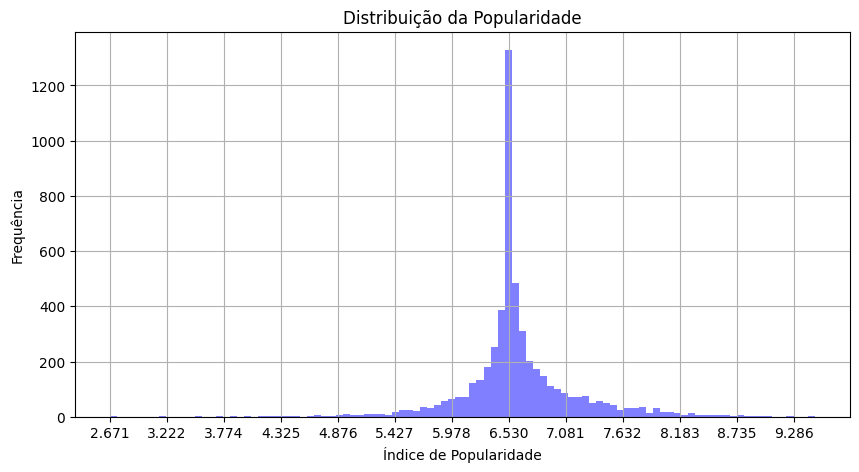

In [44]:
gf.grafico_histograma(netflix, 'popularity', 100, (netflix['popularity'].mean())/12, 'Distribuição da Popularidade', 'Índice de Popularidade')

Podemos observar que a popularidade está muito concentrada entre 6 e 7, reduzindo drasticamente a quantidade de títulos com notas fora desse intervalo.

Em seguida, vamos verificar como o nosso índice de popularidade se compara com a avaliação no IMDB:

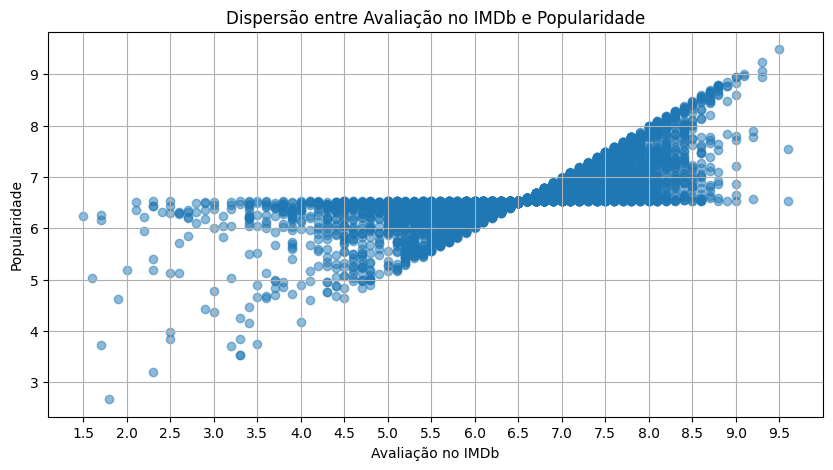

In [45]:
gf.cria_grafico_dispersao(netflix, 0.5, 'imdb_score', 'popularity', 'Dispersão entre Avaliação no IMDb e Popularidade', 'Avaliação no IMDb', 'Popularidade')

Nessa dispersão entre Popularidade x Avaliação no IMDb, podemos observar alguns pontos interessantes:

- Há alguns títulos com avaliação muito alta no IMDB, mas com popularidade relativamente baixa. Isso ocorre porque a contagem de votos tem um peso maior na nossa medida de popularidade.
- Há também alguns títulos com avaliação muito baixa no IMDB, mas com popularidade alta relativamente alta. Isso também se explica pelo peso da contagem de votos na nossa medida de popularidade. Percebemos aqui que o nosso ponderamento corrige a distorção causada pela avaliação isolada, dando mais importância ao número de avaliações na hora de calcular a popularidade.

Em seguida, vamos fazer uma dispersão entre número de votos e popularidade para verificar novamente:

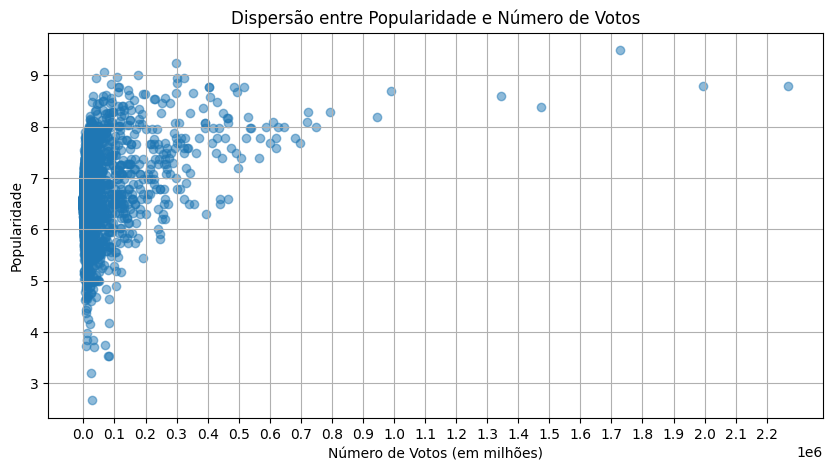

In [46]:
gf.cria_grafico_dispersao(netflix, 100000, 'imdb_votes', 'popularity', 'Dispersão entre Popularidade e Número de Votos', 'Número de Votos (em milhões)', 'Popularidade')

Nesse gráfico, podemos confirmar o que dissemos anteriormente: a popularidade cresce bastante à medida que o número de votos no IMDb aumenta. Observe que títulos com mais de 100 mil votos têm quase todos popularidade superior a 5. Além disso, nenhum título com mais de 500 mil votos tem popularidade inferior a 7.

### Títulos mais populares

Agora vamos verificar quais são os títulos mais populares e menos populares da Netflix no IMDb? Pensando em nosso ponderamento, temos que os 10 títulos mais populares são:

In [47]:
netflix.head(10)

,title,type,imdb_id,imdb_score,imdb_votes,popularity
0,Breaking Bad,SHOW,tt0903747,9.5,1727694.0,9.489394
1,Avatar: The Last Airbender,SHOW,tt0417299,9.3,297336.0,9.243500
2,Kota Factory,SHOW,tt9432978,9.3,66985.0,9.065661
3,Arcane,SHOW,tt11126994,9.1,175412.0,9.012395
4,The Last Dance,SHOW,tt8420184,9.1,108321.0,8.961072
5,Attack on Titan,SHOW,tt2560140,9.0,325381.0,8.953887
6,DEATH NOTE,SHOW,tt0877057,9.0,302147.0,8.950412
7,Our Planet,SHOW,tt9253866,9.3,41386.0,8.939595
8,Seinfeld,SHOW,tt0098904,8.9,302700.0,8.852508
9,Hunter x Hunter,SHOW,tt2098220,9.0,87857.0,8.837436


Observamos dois aspectos:

- Todos são do tipo SHOW;
- O ponderamento é evidente, pois a maioria deles tem um número expressivo de votos. Isso mostra que a comunidade se envolve muito em avaliar os títulos que julgam de alta qualidade.

A seguir, vamos analisar os 10 títulos menos populares:

In [48]:
netflix.tail(10)

,title,type,imdb_id,imdb_score,imdb_votes,popularity
5273,365 Days: This Day,MOVIE,tt12996154,2.5,10739.0,3.976168
5274,Cuties,MOVIE,tt9196192,3.3,30030.0,3.853262
5275,Cosmic Sin,MOVIE,tt11762434,2.5,12284.0,3.852775
5276,Scary Movie 5,MOVIE,tt0795461,3.5,70814.0,3.744171
5277,Himmatwala,MOVIE,tt2802286,1.7,8550.0,3.731496
5278,The Open House,MOVIE,tt7608028,3.2,33769.0,3.717015
5279,365 Days,MOVIE,tt10886166,3.3,80198.0,3.532000
5280,Jack and Jill,MOVIE,tt0810913,3.3,83727.0,3.522896
5281,Nothing to Lose,MOVIE,tt6910020,2.3,23016.0,3.198276
5282,Racket Boys,SHOW,tt14482414,1.8,27484.0,2.671141


Observamos dois aspectos: 

- Todos são do tipo MOVIE;
- A popularidade é influenciada pelo número de votos, pois a maioria deles tem um número significativo de votos (acima da média truncada, por exemplo), embora menor do que os 10 mais populares). Isso indica que a comunidade também se interessa em avaliar os títulos que consideram de baixa qualidade.

### Títulos: SHOW vs. MOVIE

Primeiramente, vamos separar os nossos títulos em dois dataframes, um para séries e outro para filmes, e fazer uma representação gráfica para ver a proporção de cada tipo no total.

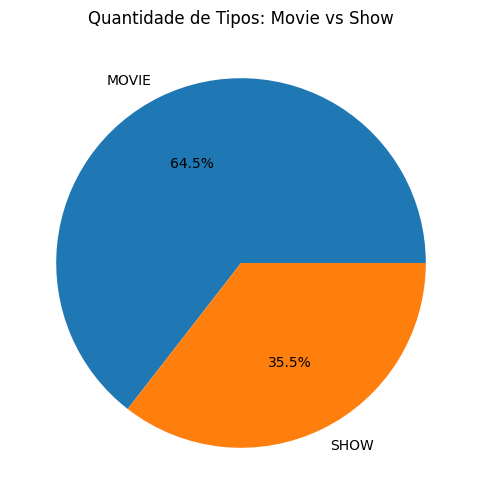

In [49]:
netflix_movies = netflix[netflix['type'] == 'MOVIE']
netflix_shows = netflix[netflix['type'] == 'SHOW']
type_counts = netflix['type'].value_counts()
type_counts.plot(kind='pie', figsize=(6, 6), autopct='%1.1f%%')
plt.title('Quantidade de Tipos: Movie vs Show')
plt.ylabel('')
plt.show()

Vejamos como estão nossos dados tipos `MOVIE`:

In [50]:
netflix_movies.describe()

,imdb_score,imdb_votes,popularity
count,3407.000000,3.407000e+03,3407.000000
mean,6.266980,2.657027e+04,6.505901
std,1.117282,9.450162e+04,0.514486
min,1.500000,5.000000e+00,3.198276
25%,5.600000,5.840000e+02,6.341186
50%,6.400000,2.632000e+03,6.523014
75%,7.100000,1.210950e+04,6.653724
max,9.000000,2.268288e+06,8.793823


Vejamos como estão nossos dados tipo `SHOW`:

In [51]:
netflix_shows.describe()

,imdb_score,imdb_votes,popularity
count,1876.000000,1.876000e+03,1876.000000
mean,7.017377,1.748556e+04,6.812293
std,1.079717,7.107211e+04,0.548772
min,1.600000,5.000000e+00,2.671141
25%,6.400000,4.445000e+02,6.530520
50%,7.200000,1.782000e+03,6.612969
75%,7.800000,7.216750e+03,6.970692
max,9.600000,1.727694e+06,9.489394


Aqui, temos a impressão de que as séries são mais populares entre os usuários, de acordo com o nosso índice, mesmo tendo um número bem menor de representantes.

### Popularidade: SHOW vs. MOVIE

Antes de mais nada, vamos usar o teste de Shapiro-Wilk para verificar a normalidade dos dados. O teste retorna dois valores: a estatística de teste (W) e o valor-p.

- A estatística de teste (W) é um número entre 0 e 1. Um valor de W próximo de 1 indica que os dados seguem uma distribuição normal, enquanto um valor de W bem menor que 1 indica que os dados não são normalmente distribuídos.
- O valor-p é usado para decidir se devemos rejeitar ou não a hipótese nula. A hipótese nula para o teste de Shapiro-Wilk é que os dados são normalmente distribuídos. Se o valor-p for menor que o nível de significância (0,05), rejeitamos a hipótese nula e concluímos que os dados não são normalmente distribuídos.

In [52]:
# Teste de Shapiro-Wilk
stat, p = stats.shapiro(netflix_movies['popularity'])
print(f'Movies: Statistics={stat}, p={p}')
stat, p = stats.shapiro(netflix_shows['popularity'])
print(f'Shows: Statistics={stat}, p={p}')

Movies: Statistics=0.8971103429794312, p=4.988622532996349e-43
Shows: Statistics=0.8213093876838684, p=1.643022449420848e-41


Os dois conjuntos de dados tiveram estatísticas de teste (W) menores que 1 e valores-p muito baixos, indicando que os dados não seguem uma distribuição normal. Portanto, não vamos aplicar métodos estatísticos que pressupõem a normalidade dos dados.

Veja a distribuição em histograma:

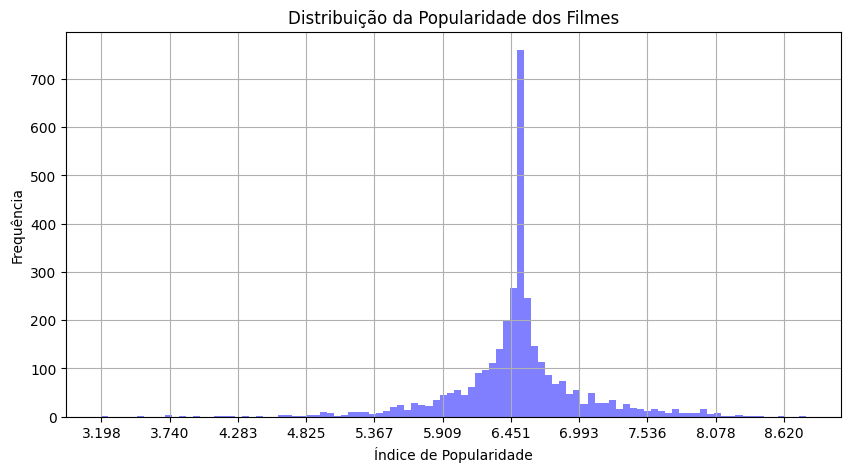

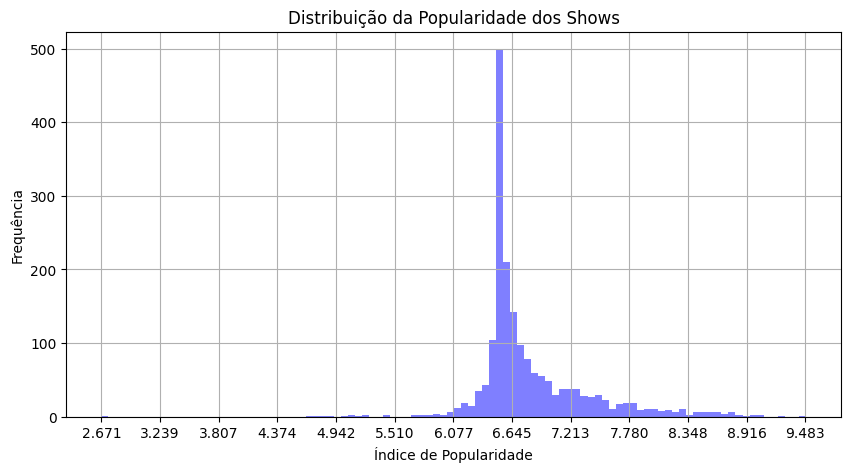

In [53]:
gf.grafico_histograma(netflix_movies, 'popularity', 100, (netflix_movies['popularity'].mean())/12, 'Distribuição da Popularidade dos Filmes', 'Índice de Popularidade')
gf.grafico_histograma(netflix_shows, 'popularity', 100, (netflix_shows['popularity'].mean())/12, 'Distribuição da Popularidade dos Shows', 'Índice de Popularidade')

Como os dados não seguem uma distribuição normal, vamos aplicar outras duas técnicas:

- Teste de Mann-Whitney U: para verificar se as medianas dos dois grupos são diferentes;
- Mediana e Intervalo Interquartil: calcula a mediana e o IQR de cada grupo. O IQR é a diferença entre o Q3 e o Q1 e indica a variação dos dados.

In [54]:
# Teste de Mann-Whitney U
u_stat, p_val = stats.mannwhitneyu(netflix_movies['popularity'], netflix_shows['popularity'])
print(f'U-statistic: {u_stat}')
print(f'P-value: {p_val}')

# Cálculo da mediana e do IQR para filmes e shows
median_movies = netflix_movies['popularity'].median()
iqr_movies = netflix_movies['popularity'].quantile(0.75) - netflix_movies['popularity'].quantile(0.25)
median_shows = netflix_shows['popularity'].median()
iqr_shows = netflix_shows['popularity'].quantile(0.75) - netflix_shows['popularity'].quantile(0.25)
print(f'Movies: Mediana={median_movies}, IQR={iqr_movies}')
print(f'Shows: Mediana={median_shows}, IQR={iqr_shows}')

U-statistic: 2024322.0
P-value: 4.762856478098458e-108
Movies: Mediana=6.523013925895122, IQR=0.3125379351559676
Shows: Mediana=6.612969091674372, IQR=0.44017223675903594


Observamos que:

- Os resultados do teste de Mann-Whitney U, que incluem uma estatística U de 2024322.0 e um valor-p praticamente zero, fornecem evidências fortes de que as distribuições de popularidade para filmes e shows são diferentes. O valor muito baixo do valor-p nos permite rejeitar a hipótese nula de que as distribuições são iguais, indicando que há uma diferença estatisticamente significativa entre as popularidades dos filmes e dos shows.
- A mediana da popularidade para filmes foi de cerca de 6.52, enquanto para shows foi de cerca de 6.61. Isso indica que, em média, os shows tendem a ser mais populares do que os filmes na plataforma.
- Ao considerar a variação dos dados, medida pelo Intervalo Interquartil (IQR), notamos que os shows apresentam uma maior variabilidade na popularidade (IQR cerca de 0.44) em comparação com os filmes (IQR cerca de 0.31). Isso sugere que, embora os shows possam ser mais populares em média, a popularidade individual dos shows varia mais amplamente.

Em outras palavras, embora os shows possam ser mais populares em geral, há uma maior variação na popularidade entre diferentes shows. Isso pode ser interpretado como um sinal de que existem alguns shows que são muito populares, mas também muitos shows que são menos populares. Em contraste, a popularidade dos filmes parece ser mais consistente, com uma variação menor entre diferentes filmes.

Portanto, embora os shows pareçam ser a opção mais popular entre os usuários em geral, os filmes também têm um público fiel na plataforma.

## Conclusão:

Neste projeto, estudamos a popularidade dos conteúdos da Netlifx disponíveis na plataforma IMDb, com o objetivo de compreender como ela é influenciada por fatores como avaliação, número de votos e tipo de conteúdo.

O índice de popularidade foi calculado usando a Média de Bayes, uma medida que combina a avaliação média com o número de votos. Essa medida foi escolhida e formulada de modo que desse mais peso ao número de votos, o que considera o engajamento que o título gerou na plataforma. O teste de Mann-Whitney U foi usado para comparar a popularidade entre filmes e séries. A mediana e o intervalo interquartil foram usados para descrever a distribuição da popularidade dentro de cada tipo de conteúdo.

Ao responder nossas perguntas, tivemos as seguintes conclusões:

- Como podemos avaliar a popularidade de um conteúdo baseado nessas informações que temos? Ao observarmos as avaliações médias e a quantidade de votos, podemos elaborar um ponderamento para que possamos usar ambos em nossa análise. Isso foi feito para evitar distorções e também para dar mais atenção ao engajamento que os conteúdos geraram.

- Quais são os conteúdos mais populares disponíveis? Os conteúdos mais populares disponíveis são, em geral, aqueles com maior avaliação média e maior número de votos.

- Pensando em popularidade, filmes ou séries são mais populares? As séries tendem a ser mais populares do que os filmes.

- Há influência do tipo de conteúdo na popularidade? Sim, há uma diferença estatisticamente significativa entre a popularidade dos filmes e das séries. As séries tendem a ser mais populares e mais variáveis do que os filmes. Isso pode indicar que os usuários preferem assistir e avaliar séries, mas também que há uma maior diversidade de recepção entre elas.

Portanto, podemos criar um índice de popularidade influenciado por fatores como avaliação e número de votos. Os conteúdos mais populares são, em geral, aqueles com maior avaliação média e maior número de votos porém com mais peso na quantidade de votos. As séries tendem a ser mais populares do que os filmes, e também têm uma maior variabilidade na popularidade.